**Gaussian Processes for circuitpython**

Funktioniert ganz gut. Also Theoretisch kann man alle Funktionen mit Hilfe der numpy Funktionen aus der reduzierten circuitpython Version mehr oder weniger nachschreiben.

Blöderweise bekomme ich aber so ein komisches Rauschen rein. Das müsste an der cholesky transfomation in sample_multivariante_normal_1d liegen. Ich bin mir aber nicht sicher.

Komisch ist aber, dass es im Test rauschfrei funktioniert und erst im gaussian process rauscht. Das spricht dann eher fürs Invertieren der Matrix in gp_prediction... ok, ich denke das könnte es eher sein.

Ansonsten bräcuhten wir noch einen Ersatz für from scipy.spatial.distance import cdist oder eine andere geeignete Kernelfunktion, die schöne Dinge macht.

this is box mueller


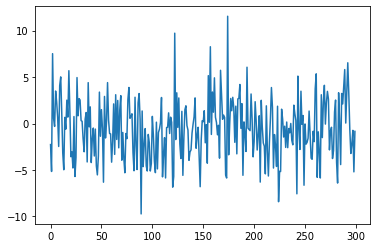

In [9]:
import numpy as np
import math
import random
from scipy.spatial.distance import cdist
import scipy

def rbf_kernel(x1, x2, varSigma, lengthscale, noise):
    #x1 = np.squeeze(x1)
    #x2 = np.squeeze(x2)
    if x2 is None:
        d = cdist(x1, x1) # euklidischer abstand sqrt( sum( ( x-xi )**2 ) )
    else:
        d = cdist(x1, x2)
    
    K = varSigma*np.exp(-np.power(d, 2)/lengthscale)
    #print(d.shape)
    #print(K.shape)
    return K

def white_kernel(x1, x2, varSigma):
    if x2 is None:
        return varSigma*np.eye(x1.shape[0])
    else:
        return np.zeros( (x1.shape[0], x2.shape[0]))

def lin_kernel(x1, x2, varSigma):
    if x2 is None:
        return varSigma*np.dot(x1 , x1.transpose() )
    else:
        return varSigma*np.dot(x1, x2.transpose() )
        

def box_muller_1d(dummy,epsilon=1e-14):
    # Avoid getting u == 0.0
    u1, u2 = 0.0, 0.0
    while u1 < epsilon or u2 < epsilon:
        u1 = random.random() #between 0 and 1
        u2 = random.random()        
    return math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)

# Our sample function of N(0,1) using Equation 5
def sampleN_v1(dummy,N=25000):
    return 2.0 * math.sqrt(N) * (sum(random.random() for x in range(N)) / N - 0.5)

def sample_gauss_box_mueller_1d(mu,sigma,size):
    print("this is box mueller")
    xx = np.vectorize(box_muller_1d)
    # use this for tests... box muller is faster
    #print("this is box sampleN_v1")
    #xx = np.vectorize(sampleN_v1)
    return xx(np.empty(size)) * sigma + mu

def sample_multivariante_normal_1d(mu,K,epsilon=10):
    d = len(mu)
    Kx = K + epsilon*np.eye(d)
    L = np.linalg.cholesky(Kx)
    #L = scipy.linalg.cholesky(Kx)
    u = sample_gauss_box_mueller_1d(0, 1, d )
    return mu.transpose() + np.dot(L, u)

# choose index set for the marginal
d = 300
x = np.linspace(-6, 6, d).reshape( (d, 1) )
# compute covariance matrix
K = rbf_kernel(x, None, 1.0,2.0,0 ) #, 2.0, 0)
#K = lin_kernel(x, None, 2.0 )
#K = white_kernel(x, None, 2.0 )
# create mean vector
mu = np.zeros(x.shape)
# draw samples 20 from Gaussian distribution

f = sample_multivariante_normal_1d(mu, K)

#f1 = np.random.multivariate_normal(mu, K, 10)
import matplotlib.pyplot as plt

plt.plot(np.arange(len(f[0])),f[0])
#plt.plot(np.arange(len(f1[0])),f1[0],"x")
plt.show()
plt.close()

In [10]:
N = 5
# x,y,x1,y1 have the length N
x = np.linspace(-3.1,3,N)
y = np.sin(2*np.pi/x) + x*0.1 + 0.3*np.random.randn(x.shape[0])
x1 = np.reshape(x,(-1,1))
y1 = np.reshape(y,(-1,1))

#plt.scatter(x,y)
#plt.savefig("gp/exmpl_data.png")
plt.show()
plt.close()


this is box mueller


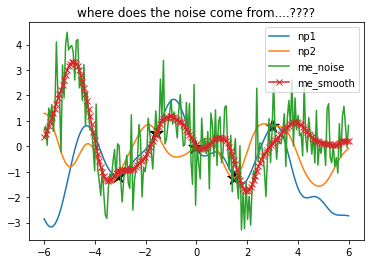

In [11]:

def gp_prediction(x1, y1, xstar, lengthScale, varSigma, noise=0):
    k_starX = rbf_kernel(xstar,x1,lengthScale,varSigma,noise)
    k_xx = rbf_kernel(x1, None, lengthScale, varSigma, noise)
    k_starstar = rbf_kernel(xstar,None,lengthScale,varSigma,noise)
    mu = k_starX.dot(np.linalg.inv(k_xx)).dot(y1)
    var = k_starstar - (k_starX).dot(np.linalg.inv(k_xx)).dot(k_starX.T)
    return mu, var, xstar

def gp_prediction_white(x1, y1, xstar, lengthScale, varSigma, noise=0):
    k_starX = white_kernel(xstar,x1,lengthScale)
    k_xx = white_kernel(x1, None, lengthScale)
    k_starstar = white_kernel(xstar,None,lengthScale)
    mu = k_starX.dot(np.linalg.inv(k_xx)).dot(y1)
    var = k_starstar - (k_starX).dot(np.linalg.inv(k_xx)).dot(k_starX.T)
    return mu, var, xstar

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box , mode='same')
    return y_smooth

def gp_smooth_full(x1,y1,x_star,y_star,n,m):
    for x in x1:
        if x in x_star:
            print("del")
            p = np.where(x==x_star)
            x_star = np.delete(x_star,p)
            y_star = np.delete(y_star,p)
    
    for i in range(m):
        x_star = np.array(list(x1.flatten())*n + list(x_star.flatten() ))
        p  = np.argsort(x_star, axis=0)
        pp = np.argsort(p, axis=0)
        x_star = x_star[p]
        y_star = np.array(list(y1.flatten())*n + list(y_star.flatten()))
        y_star = smooth(y_star[p],n)
        y_star = smooth(y_star,n)
        y_star = y_star[pp][(n-1)*len(x1):]
        x_star = x_star[pp][(n-1)*len(x1):]
        p  = np.argsort(x_star, axis=0)
        x_star = x_star[p]
        y_star = y_star[p]
    #y = smooth(y,n)
    return x_star,y_star

def gp_smooth(x1,y1,x_star,y_star,n,m):
    
    for i in range(m):
        y_star = smooth(y_star,n)
        y_star = smooth(y_star,n)
    #y = smooth(y,n)
    return x_star,y_star


# x_star has the length 500...
x_star = np.linspace(-6, 6, 200).reshape(-1, 1)

#Nsamp = 100
#mu_star, var_star, x_star = gp_prediction(x1, y1, x, lengthScale, varSigma, noise)
mu_star, var_star, x_star = gp_prediction(x1, y1, x_star,  2., 1.)
mu_star = np.squeeze(mu_star)
f_star1 = np.random.multivariate_normal(mu_star, var_star, 1)
f_star2 = np.random.multivariate_normal(mu_star, var_star, 1)

# get noisy fun from my implementation
f_star_noise = sample_multivariante_normal_1d(mu_star, var_star, 1)
# smooth noisy fun
xt,yt_smooth  = gp_smooth(x1,y1,x_star,f_star_noise,10,1)
# QUESTION:
# whats better? Smooth or fix noise? Tend to fix noise... 
# for this we need to identify the source
# --> check header/top of document

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_star, f_star1.T,label="np1")
ax.plot(x_star, f_star2.T,label="np2")
ax.plot(x_star, f_star_noise,label="me_noise")
ax.plot(xt, yt_smooth,"x-",label="me_smooth")
#ax.plot(xt1, yt1,".-",label="me3")
ax.scatter(x1, y1, 200, 'k', '*', zorder=2)
plt.title("where does the noise come from....????")
plt.legend()
plt.savefig("gp/exmpl_fun_noise.png")
plt.show()
plt.close()

In [ ]:
#print(x_star.reshape(len(x_star),1))
#print(f_star1)
print(y1)
print(np.array(list(y1.reshape(len(y1))[:])*4 + list(f_star1.reshape(len(f_star1)))))

**Euclidean Distance**

...is missing :/
...and nice :)
For rbf_kernel... oder einen ebenfalls geeigneten Kernel suchen...

In [ ]:
a = np.array([[1,1,1,1],[1,2,3,4]])
np.linalg.norm( [1,2] )

In [ ]:
c = [(35.0456, -85.2672),
          (35.1174, -89.9711),
          (35.9728, -83.9422),
          (36.1667, -86.7833)]

c = [ [1,2,3,5], [2,2,3,4], [2,2,3,4] ]
cdist(c,c)

In [ ]:
np.linalg.norm( [1,2] )

In [ ]:
np.sqrt( (1-2)**2 )

In [ ]:
np.sqrt( sum( [  (a-b)**2 for a,b in zip(c[0] , c[1]) ] ))

**Glätten**

convolution...

In [ ]:
np.convolve(  np.array([1, 1, 5, 5,6,6,7,7]),np.array([1]) , mode='same')